In [1]:

import os
import gym
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
from datetime import datetime
from scipy.optimize import minimize
from joblib import Parallel, delayed
from IPython.display import display

from mdp_extras import vi, OptimalPolicy, padding_trick, UniformRandomCtsPolicy, PaddedMDPWarning, Linear
from mdp_extras.envs import VonMisesNormalBasis, pendulum_obs_to_state

from unimodal_irl import sw_maxent_irl, sw_maxent_irl_modelfree, mean_ci, ile_evd, inner_angle


In [2]:

from gym.wrappers import TimeLimit
from gym.envs.classic_control import PendulumEnv

from stable_baselines3 import DDPG

#env = gym.make("Pendulum-v0")
max_timesteps = 200
env = PendulumEnv()
env = TimeLimit(env, max_timesteps)
gamma = 0.99

# Load trained DDPG policy from rl-baselines3-zoo
model = DDPG.load(
    os.path.join("rl-trained-agents/ddpg/Pendulum-v0_1/Pendulum-v0.zip"),
    env=env,
    custom_objects=dict(learning_rate=0.001)
)


C:\Users\snoswell\Miniconda3\envs\py38\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [3]:

# Collect demonstrations from expert policy
num_demos = 20
demos = []
for _ in range(num_demos):
    obs = env.reset()
    traj = []
    while True:
        state = pendulum_obs_to_state(obs)
        action, _ = model.predict(obs)
        traj.append((state, action))
        obs, reward, done, info = env.step(action)
        #env.render()
        if done:
            break
    demos.append(traj)
    #env.close()


[[1.37228931e-04 2.60523678e-01 2.81397210e+01 1.74939481e-01
  3.41200528e-05]
 [2.31296580e-01 6.76056018e-01 2.59988624e-01 1.51151544e-01
  8.23808584e-03]
 [5.44339201e-01 1.68049880e-01 3.72317137e-01 2.68556664e-01
  1.39230871e-01]
 [3.83788671e-01 3.49575355e-01 4.83818746e-01 4.43847770e-01
  1.64711023e-01]
 [1.14475265e-02 3.09312827e-01 3.71189662e-01 3.37865406e-01
  7.78023274e-02]]


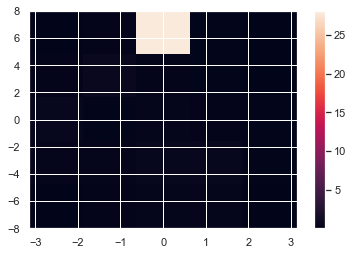

In [4]:

basis_dim = 5
phi = VonMisesNormalBasis(num=basis_dim, kappa=10, std=1.0)

# Visualise feature function
# num = 20
# t = np.linspace(-np.pi, np.pi, num)
# td = np.linspace(-8.0, 8.0, num)

# X, Y = np.meshgrid(t, td)
# Z = np.zeros([X.shape[0], X.shape[1], basis_dim ** 2])
# for id0 in range(X.shape[0]):
#     for id1 in range(X.shape[1]):
#         _x = X[id0, id1]
#         _y = Y[id0, id1]
#         Z[id0, id1] = phi([_x, _y])

# import matplotlib.pyplot as plt

# for _idx in range(basis_dim ** 2):
#     plt.figure()
#     _Z = Z[:, :, _idx]
#     plt.contour(X, Y, _Z)
#     plt.show()
#     plt.close()

phi_bar = phi.demo_average(demos, gamma)

print(phi_bar.reshape(basis_dim, -1))

def viz_soln(x):
    """Visualize a solution vector"""
    #plt.figure(figsize=(7, 6), dpi=300)
    plt.figure()
    sns.set()
    plt.imshow(x.reshape(basis_dim, -1), aspect="auto", extent=(-np.pi, np.pi, -8.0, 8.0))
    plt.colorbar()
    plt.show()

# Visualize expert's feature expectation
viz_soln(phi_bar)



# Value function is given by:

$$
v_\pi(s) \triangleq \mathbb{E}_\pi\left[
    \sum_{k=0}^\infty \gamma^k r(s_{t+k+1}) \mid s_t = s
\right]
$$

Therfore, for a given policy we can approximate this by,

$$
v_\pi(s) \approx \frac{1}{|M|} \sum_{i=1}^M
\left[
    r(s) + r(s') + \dots \mid T, \pi
\right];
\qquad\qquad \tau_i \sim \pi
$$

This approximation will have much lower variance for a deterministic policy, and will be exact up to numerical rounding for the case of a deterministic policy AND detemrinistic dynamics.


In [5]:


def approx_state_value(pi, s, num_samples=1, gamma=1.0, r_custom=None):
    """Approximately compute the value of s under pi
    
    Args:
        pi (class): Policy object with a .predict() method matching the stable-baselines API
        s (numpy array): State to estimate value from
        
        num_samples (int): Number of samples to estimate value with. For
            determinstic policies and transition dynamics this can be set to 1.
        gamma (float): Discount factor
        r_custom (mdp_extras.RewardFunction): Custom reward function to use
    
    Returns:
        (float): State value estimate
    """
    
    episode_returns = []
    for _ in range(num_samples):
        # XXX Force initial state
        env.reset()
        env.unwrapped.state = s
        obs = env.unwrapped._get_obs()
        done = False
        ep_rewards = []
        while not done:
            a = pi.predict(obs, deterministic=True)[0]
            obs, reward, done, info = env.step(a)
            if r_custom is not None:
                # Use custom reward function
                state = pendulum_obs_to_state(obs)
                reward = r_custom(phi(state))
            ep_rewards.append(reward)
            if done:
                break
        ep_rewards = np.array(ep_rewards)
        gammas = gamma ** np.arange(len(ep_rewards))
        episode_return = gammas @ ep_rewards
        episode_returns.append(episode_return)
    
    return np.mean(episode_returns)


def approx_policy_value(pi, start_state_disc_dim=10, num_samples=1, gamma=1.0, r_custom=None, n_jobs=8):
    """Approximately compute the value pi under the starting state distribution
    
    Args:
        pi (class): Policy object with a .predict() method matching the stable-baselines API
    
        start_state_disc_dim (int): How fine to discretize each dimension of the MDP starting
            state distribution support. For Pundulum-v0, 10 seems to be sufficient for accurately
            measuring policy value (at least for the optimal policy)
        num_samples (int): Number of samples to estimate value with. For
            determinstic policies and transition dynamics this can be set to 1.
        gamma (float): Discount factor
        r_custom (mdp_extras.RewardFunction): Custom reward function to use
        n_jobs (int): Number of parallel workers to spin up for estimating value
        
    Returns:
        (float): Approximate value of pi under the MDP's start state distribution
    """
    # Compute a set of states that span and discretize the continuous uniform start state distribution
    theta_bounds = np.array([-np.pi, np.pi])
    theta_delta = 0.5 * (theta_bounds[1] - theta_bounds[0]) / start_state_disc_dim
    theta_bounds += np.array([theta_delta, -theta_delta])
    thetas = np.linspace(theta_bounds[0], theta_bounds[1], start_state_disc_dim)
    theta_dots = np.linspace(-1, 1, start_state_disc_dim)
    start_states = [np.array(p) for p in it.product(thetas, theta_dots)]
    
    # Spin up a bunch of workers to process the starting states in parallel
    values = Parallel(n_jobs=n_jobs)(
        delayed(approx_state_value)(model, state, num_samples, gamma, r_custom)
        for state in start_states
    )
    
    return np.mean(values)

# What is the value of the optimal policy?
pi_gt_v = approx_policy_value(model)
print(pi_gt_v)
# -144 is *just* sufficient to make it to the OpenAI Gym leaderboard - so we're in the right ball-park

def evd(learned_model, gamma):
    """Compute approximate expected value difference for a learned optimal policy
    
    Args:
        learned_model (class): Optimal policy wrt. some reward function. Should be a Policy
            object with a .predict() method matching the stable-baselines API
        
        gamma (float): Discount factor
        
    Returns:
        (float): Expected value difference of the given policy
    """
    v_pi = approx_policy_value(learned_model, gamma=gamma)
    evd = pi_gt_v - v_pi
    return evd



C:\Users\snoswell\Miniconda3\envs\py38\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


-151.91558688482775


In [6]:

pi_ref = UniformRandomCtsPolicy((-2.0, 2.0))

 # Get importance sampling dataset
pi_ref_demos = []
max_path_length = max_timesteps
num_sampled_paths = 10
for _ in range(num_sampled_paths):
    path_len = np.random.randint(1, high=max_path_length + 1)
    path = []
    obs = env.reset()
    s = pendulum_obs_to_state(obs)
    while len(path) < path_len - 1:
        a = pi_ref.predict(s)[0]
        path.append((s, a))
        obs, r, done, _ = env.step(a)
        s = pendulum_obs_to_state(obs)
    path.append((s, None))
    pi_ref_demos.append(path)

# Pre-compute sampled path feature expectations
pi_ref_demo_phis_precomputed = [
    phi.onpath(p, gamma)
    for p in pi_ref_demos
]


In [7]:

# Nelder Mead doesn't work - the scipy implementation doesn't support bounds or callback termination signals


      fun: 219.59440427392983
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.10626221e-04,  1.88272476e-01, -2.37392273e+01,  8.45067978e-01,
        1.06430054e-03,  1.30319595e-01,  4.74283218e-01,  3.04094315e-01,
        1.46805191e+00,  1.91654205e-01,  5.09019852e-01,  1.17504120e-01,
        1.75292969e-01, -2.56290436e-02,  1.09290314e+00,  7.13958740e-01,
       -5.00736237e-02, -2.23159790e-04, -2.55084991e-01,  8.86604309e-01,
        1.86901093e-01,  1.10220718e+00,  1.12291336e-01,  4.98252869e-01,
        3.96768570e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 780
      nit: 24
     njev: 30
   status: 0
  success: True
        x: array([-0.00318264, -1.        ,  1.        , -1.        , -0.02982608,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        ,  1.        , -1.        ,
       -1.        ,  1.        ,  0.58245427,  1.        , -1.    

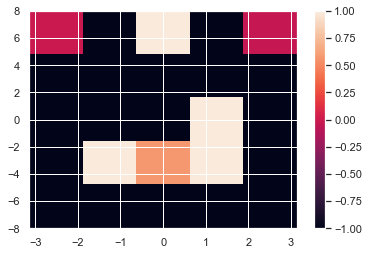

In [11]:

x0 = np.zeros(len(phi))
res = minimize(
    sw_maxent_irl_modelfree,
    x0,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
    method='L-BFGS-B',
    jac='2-point',
    bounds=[(-1, 1) for _ in range(len(phi))],
    options=dict(disp=True)
)

print(res)
viz_soln(res.x)


In [19]:

from gym.envs.classic_control import PendulumEnv
from stable_baselines3.common.vec_env import DummyVecEnv

class CustomPendulumEnv(PendulumEnv):
    
    def __init__(self, reward_fn, g=10.0):
        super().__init__(g=g)
        self._reward_fn = reward_fn
    
    def step(self, a):
        obs, r, done, info = super().step(a)
        state = super().unwrapped.state
        r2 = self._reward_fn(phi(state))
        return obs, r2, done, info

get_env = lambda: CustomPendulumEnv(reward_fn=Linear(res.x))
num_envs = 1
env2 = DummyVecEnv([get_env for _ in range(num_envs)])
model = DDPG('MlpPolicy', env2, verbose=1)
model.learn(total_timesteps=1000)


Using cuda device


KeyboardInterrupt: 

In [10]:

assert False


AssertionError: 

      fun: 219.5933724968353
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.12277275e-04,  1.88184917e-01, -2.37400734e+01,  8.44869648e-01,
        1.06665640e-03,  1.30249298e-01,  4.74062911e-01,  3.03993954e-01,
        1.46773864e+00,  1.91614270e-01,  5.08820740e-01,  1.17928882e-01,
        1.76329431e-01, -2.53337666e-02,  1.09266498e+00,  7.13747949e-01,
       -4.96295686e-02,  6.94383419e-04, -2.54768248e-01,  8.86402897e-01,
        1.86860944e-01,  1.10193582e+00,  1.12207664e-01,  4.98092263e-01,
        3.96675949e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2142
      nit: 34
     njev: 42
   status: 0
  success: True
        x: array([ 0.02458339, -1.        ,  1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        ,  1.        , -1.        ,
       -1.        ,  1.        ,  0.5826262 ,  1.        , -1.    

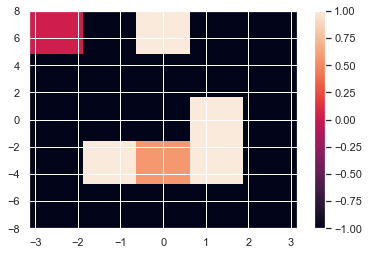

In [9]:

x0 = np.zeros(len(phi))
res = minimize(
    sw_maxent_irl_modelfree,
    x0,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
    method='L-BFGS-B',
    jac='3-point',
    bounds=[(-1, 1) for _ in range(len(phi))],
    options=dict(disp=True)
)

print(res)
viz_soln(res.x)


In [ ]:

x0 = np.zeros(len(phi))

res = minimize(
    sw_maxent_irl_modelfree,
    x0,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, False, pi_ref_demo_phis_precomputed),
    method='L-BFGS-B',
    jac=True,
    bounds=[(-1, 1) for _ in range(len(phi))],
    options=dict(disp=True)
)

print(res)
viz_soln(res.x)


In [ ]:

import cma

x0 = np.zeros(len(phi))
x, es = cma.fmin2(
    sw_maxent_irl_modelfree,
    x0,
    0.5,
    args=(gamma, phi, phi_bar, max_path_length, pi_ref, pi_ref_demos, True, pi_ref_demo_phis_precomputed),
    options=dict(bounds=[-1.0, 1.0])
)

print(x.reshape(basis_dim, -1))

viz_soln(x)
